In [1]:
import pandas as pd
import numpy as np
import os
import wrangle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression 
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.pipeline import make_pipeline

In [2]:
def new_zillow_db():
    '''The function uses the get_connection function to connect to a database and retrieve the zillow dataset'''
    
    zillow = pd.read_sql('''SELECT p.bathroomcnt, p.bedroomcnt, p.calculatedfinishedsquarefeet,
    p.fips, p.garagecarcnt, p.lotsizesquarefeet, p.regionidcity, p.regionidcounty, p.regionidzip,
    p.roomcnt, p.yearbuilt, p.taxvaluedollarcnt, pd.transactiondate, pd.logerror
    FROM properties_2017 as p

    JOIN predictions_2017 as pd
    on p.id = pd.id
    LEFT JOIN propertylandusetype USING(propertylandusetypeid)

    WHERE propertylandusedesc IN ("Single Family Residential")
    AND pd.transactiondate BETWEEN '2017-01-01' AND '2017-12-31'
    AND p.bedroomcnt > 0
    AND p.bathroomcnt > 0
    AND p.calculatedfinishedsquarefeet IS NOT NULL
    AND p.lotsizesquarefeet IS NOT NULL
    AND p.taxvaluedollarcnt IS NOT NULL
    AND p.yearbuilt IS NOT NULL
    ;''', wrangle.get_connection('zillow'))
    return zillow


In [3]:
df = new_zillow_db()

In [4]:
df

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,taxvaluedollarcnt,transactiondate,logerror
0,2.0,3.0,1556.0,6037.0,NaN,6081.0,396054.0,3101.0,96437.0,0.0,1928.0,446410.0,2017-01-11,0.053789
1,1.0,2.0,909.0,6037.0,NaN,6272.0,396054.0,3101.0,96437.0,0.0,1941.0,429963.0,2017-01-11,-0.070964
2,3.0,3.0,2353.0,6037.0,NaN,5946.0,396054.0,3101.0,96437.0,0.0,1941.0,261132.0,2017-01-11,0.244329
3,1.0,2.0,909.0,6037.0,NaN,6023.0,396054.0,3101.0,96437.0,0.0,1941.0,65940.0,2017-01-11,0.004642
4,2.0,4.0,2351.0,6037.0,NaN,6033.0,396054.0,3101.0,96437.0,0.0,1941.0,424872.0,2017-01-11,0.038661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55353,3.0,5.0,3299.0,6111.0,3.0,20810.0,34278.0,2061.0,96383.0,10.0,1990.0,1337000.0,2017-09-11,0.048044
55354,2.5,4.0,2560.0,6111.0,2.0,17068.0,34278.0,2061.0,96383.0,8.0,1987.0,427624.0,2017-09-11,0.038018
55355,3.0,4.0,2887.0,6111.0,2.0,9728.0,34278.0,2061.0,96383.0,8.0,1987.0,867022.0,2017-09-10,0.042668
55356,3.0,4.0,2887.0,6111.0,2.0,10561.0,34278.0,2061.0,96383.0,8.0,1987.0,870000.0,2017-09-09,0.036466


In [5]:
df.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,taxvaluedollarcnt,logerror
count,55358.000000,55358.000000,55358.000000,55358.000000,18164.000000,5.535800e+04,54405.000000,55358.000000,55318.000000,55358.000000,55358.000000,5.535800e+04,55358.000000
mean,2.251039,3.310705,1867.476625,6048.801727,1.923365,1.107519e+04,35498.771657,2558.209166,96594.196048,1.895860,1961.094404,4.553629e+05,0.016864
std,0.989187,0.922311,959.697109,21.158768,0.572225,8.448655e+04,54191.675412,788.665158,4293.384320,3.159651,21.847146,5.891885e+05,0.172400
min,1.000000,1.000000,320.000000,6037.000000,0.000000,5.000000e+02,3491.000000,1286.000000,95982.000000,0.000000,1862.000000,7.584000e+03,-4.655420
25%,2.000000,3.000000,1262.000000,6037.000000,2.000000,5.693000e+03,12447.000000,1286.000000,96193.000000,0.000000,1949.000000,1.884075e+05,-0.024401
50%,2.000000,3.000000,1630.000000,6037.000000,2.000000,6.800000e+03,24832.000000,3101.000000,96389.000000,0.000000,1958.000000,3.300960e+05,0.006775
75%,3.000000,4.000000,2214.000000,6059.000000,2.000000,8.619000e+03,44116.000000,3101.000000,96987.000000,5.000000,1976.000000,5.333148e+05,0.039531
max,20.000000,25.000000,26345.000000,6111.000000,13.000000,6.971010e+06,396556.000000,3101.000000,399675.000000,86.000000,2016.000000,3.016684e+07,5.262999


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55358 entries, 0 to 55357
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   55358 non-null  float64
 1   bedroomcnt                    55358 non-null  float64
 2   calculatedfinishedsquarefeet  55358 non-null  float64
 3   fips                          55358 non-null  float64
 4   garagecarcnt                  18164 non-null  float64
 5   lotsizesquarefeet             55358 non-null  float64
 6   regionidcity                  54405 non-null  float64
 7   regionidcounty                55358 non-null  float64
 8   regionidzip                   55318 non-null  float64
 9   roomcnt                       55358 non-null  float64
 10  yearbuilt                     55358 non-null  float64
 11  taxvaluedollarcnt             55358 non-null  float64
 12  transactiondate               55358 non-null  object 
 13  l

In [7]:
df.bedroomcnt = df.bedroomcnt.astype(int)
    # change year built to an integer
df.yearbuilt = df.yearbuilt.astype(int)
    # change fips to an integer
df.fips = df.fips.astype(int)
    # rename columns for readability
df = df.rename(columns={'bedroomcnt': 'bedrooms', 'bathroomcnt': 'bathrooms', 'calculatedfinishedsquarefeet': 'sqft', 
                        'taxvaluedollarcnt': 'tax_value', 'yearbuilt': 'year', 'garagecarcnt':'garages',
                       'garagetotalsqft':'garagesqft'})

In [8]:
df = df.rename(columns={'lotsizesquarefeet':'lot_size', 'regionidzip':'zipcode','regionidcounty':'county',
                        'regionidcity':'city'})

In [9]:
df

,bathrooms,bedrooms,sqft,fips,garages,lot_size,city,county,zipcode,roomcnt,year,tax_value,transactiondate,logerror
0,2.0,3,1556.0,6037,NaN,6081.0,396054.0,3101.0,96437.0,0.0,1928,446410.0,2017-01-11,0.053789
1,1.0,2,909.0,6037,NaN,6272.0,396054.0,3101.0,96437.0,0.0,1941,429963.0,2017-01-11,-0.070964
2,3.0,3,2353.0,6037,NaN,5946.0,396054.0,3101.0,96437.0,0.0,1941,261132.0,2017-01-11,0.244329
3,1.0,2,909.0,6037,NaN,6023.0,396054.0,3101.0,96437.0,0.0,1941,65940.0,2017-01-11,0.004642
4,2.0,4,2351.0,6037,NaN,6033.0,396054.0,3101.0,96437.0,0.0,1941,424872.0,2017-01-11,0.038661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55353,3.0,5,3299.0,6111,3.0,20810.0,34278.0,2061.0,96383.0,10.0,1990,1337000.0,2017-09-11,0.048044
55354,2.5,4,2560.0,6111,2.0,17068.0,34278.0,2061.0,96383.0,8.0,1987,427624.0,2017-09-11,0.038018
55355,3.0,4,2887.0,6111,2.0,9728.0,34278.0,2061.0,96383.0,8.0,1987,867022.0,2017-09-10,0.042668
55356,3.0,4,2887.0,6111,2.0,10561.0,34278.0,2061.0,96383.0,8.0,1987,870000.0,2017-09-09,0.036466


In [10]:
df = df.dropna()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17836 entries, 714 to 55357
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        17836 non-null  float64
 1   bedrooms         17836 non-null  int64  
 2   sqft             17836 non-null  float64
 3   fips             17836 non-null  int64  
 4   garages          17836 non-null  float64
 5   lot_size         17836 non-null  float64
 6   city             17836 non-null  float64
 7   county           17836 non-null  float64
 8   zipcode          17836 non-null  float64
 9   roomcnt          17836 non-null  float64
 10  year             17836 non-null  int64  
 11  tax_value        17836 non-null  float64
 12  transactiondate  17836 non-null  object 
 13  logerror         17836 non-null  float64
dtypes: float64(10), int64(3), object(1)
memory usage: 2.0+ MB


In [12]:
df = df.drop(columns='city')

In [13]:
df = df.drop(columns='roomcnt')

In [14]:
df = df[df['bedrooms'] < 5]
#     # remove rows with 6 or more bathrooms
df = df[df['bathrooms'] < 4]
#     # remove rows with values less than or equal to 700 square feet
df = df[df.sqft > 700]
#     # remove rows with values greater than or equal to 10_000 square feet
df = df[df.sqft < 10000]
# remove rows with tax values greater than or equal to 600000
df = df[df.tax_value < 600000]
# remove rows with tax values less than or equal to 1000
df = df[df.tax_value > 100000]


In [15]:
df = df[df.lot_size < 10000]
df = df[df.lot_size > 1000]

In [16]:
df

,bathrooms,bedrooms,sqft,fips,garages,lot_size,county,zipcode,year,tax_value,transactiondate,logerror
715,2.5,3,2092.0,6111,2.0,8221.0,2061.0,96393.0,1986,293885.0,2017-01-06,-0.319816
716,2.5,3,1623.0,6111,2.0,5643.0,2061.0,96393.0,1985,301896.0,2017-01-06,-0.034675
717,2.5,3,1366.0,6111,2.0,3816.0,2061.0,96393.0,1984,530301.0,2017-01-06,0.023682
718,2.5,3,2466.0,6111,2.0,8615.0,2061.0,96393.0,1989,534594.0,2017-01-06,-0.018496
722,2.5,3,1785.0,6111,2.0,3057.0,2061.0,96393.0,1980,507034.0,2017-01-06,0.011821
...,...,...,...,...,...,...,...,...,...,...,...,...
55346,3.0,4,2728.0,6111,2.0,9412.0,2061.0,96385.0,1987,538347.0,2017-09-11,0.042775
55349,2.0,3,1486.0,6111,2.0,7495.0,2061.0,96385.0,1975,368481.0,2017-09-11,-0.011081
55350,2.0,4,1260.0,6111,2.0,7067.0,2061.0,96385.0,1972,193056.0,2017-09-11,-0.006472
55352,3.0,4,2205.0,6111,2.0,8544.0,2061.0,96385.0,1997,427898.0,2017-09-11,0.132464


In [17]:
df['lot_minus_home'] = df.lot_size - df.sqft

In [18]:
df

,bathrooms,bedrooms,sqft,fips,garages,lot_size,county,zipcode,year,tax_value,transactiondate,logerror,lot_minus_home
715,2.5,3,2092.0,6111,2.0,8221.0,2061.0,96393.0,1986,293885.0,2017-01-06,-0.319816,6129.0
716,2.5,3,1623.0,6111,2.0,5643.0,2061.0,96393.0,1985,301896.0,2017-01-06,-0.034675,4020.0
717,2.5,3,1366.0,6111,2.0,3816.0,2061.0,96393.0,1984,530301.0,2017-01-06,0.023682,2450.0
718,2.5,3,2466.0,6111,2.0,8615.0,2061.0,96393.0,1989,534594.0,2017-01-06,-0.018496,6149.0
722,2.5,3,1785.0,6111,2.0,3057.0,2061.0,96393.0,1980,507034.0,2017-01-06,0.011821,1272.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55346,3.0,4,2728.0,6111,2.0,9412.0,2061.0,96385.0,1987,538347.0,2017-09-11,0.042775,6684.0
55349,2.0,3,1486.0,6111,2.0,7495.0,2061.0,96385.0,1975,368481.0,2017-09-11,-0.011081,6009.0
55350,2.0,4,1260.0,6111,2.0,7067.0,2061.0,96385.0,1972,193056.0,2017-09-11,-0.006472,5807.0
55352,3.0,4,2205.0,6111,2.0,8544.0,2061.0,96385.0,1997,427898.0,2017-09-11,0.132464,6339.0


In [19]:
df = df.drop(columns=['zipcode','logerror','transactiondate'])

In [20]:
def plot_variable_hist(df):
    '''This function takes in a dataframe and returns a histogram for each variable.'''
    plt.figure(figsize=(24, 20))

    # List of columns
    cols = ['bedrooms', 'bathrooms', 'sqft', 'tax_value', 'lot_size', 'year', 'fips', 'county', 'garages', 'lot_minus_home']
    for i, col in enumerate(cols):
        # i starts at 0, but plot nos should start at 1
        subplot_num = i+1
        # Create subplot.
        plt.subplot(6,2,subplot_num)
        # Title with column name.
        plt.title(col)
        # Display histogram for column.
        df[col].hist()
        # Hide gridlines.
        plt.grid(False)

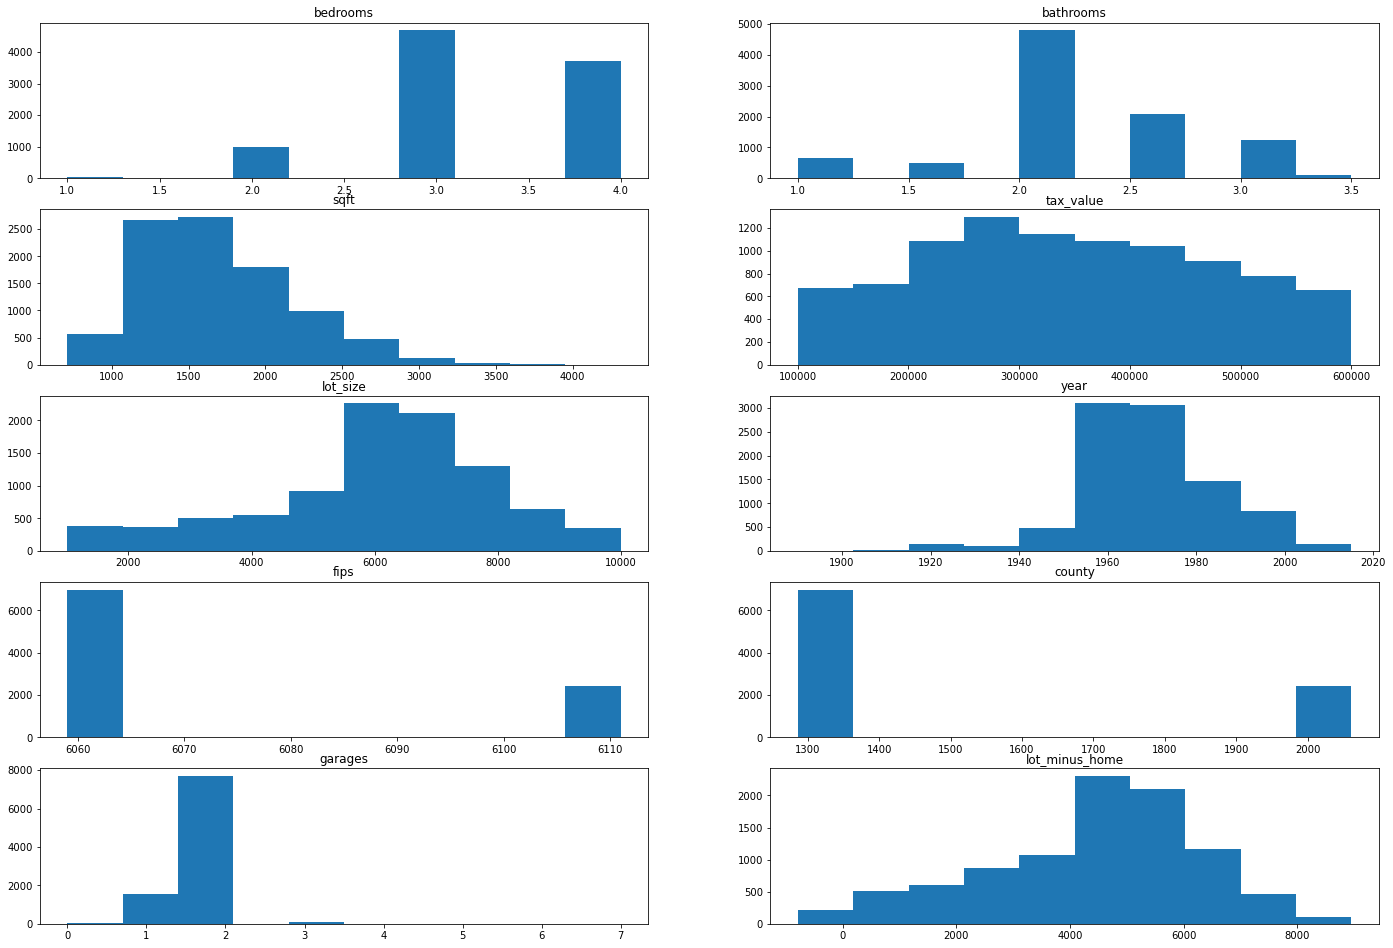

In [21]:
plot_variable_hist(df)

In [22]:
train, validate, test = wrangle.split_data(df)

In [23]:
cols = ['bathrooms','bedrooms','sqft']
X_train, y_train = train[cols], train.tax_value
X_validate, y_validate = validate[cols], validate.tax_value
X_test, y_test = test[cols], test.tax_value

In [24]:
baseline = train.tax_value.mean()

In [25]:
train['baseline'] = baseline

In [26]:
validate['baseline'] = validate.tax_value.mean()

In [27]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.minmax_scaler(X_train, X_validate, X_test)

In [28]:
ols_model = LinearRegression().fit(X_train_scaled, train.tax_value)

In [29]:
train['yhat'] = ols_model.predict(X_train_scaled)

In [30]:
y = train.tax_value
yhat = train.yhat

In [31]:
# create column for model residual error
train['residual'] = train.yhat - train.tax_value
# create column for baseline residual error
train['residual_baseline'] = train.baseline - train.tax_value

In [32]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [33]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  8.898345e+13
1    MSE  1.577721e+10
2   RMSE  1.256074e+05
          metric   model_error
0   SSE_baseline  9.544501e+13
1   MSE_baseline  1.692287e+10
2  RMSE_baseline  1.300879e+05


In [34]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,8.898345e+13,-6.461561e+12
1,MSE,1.577721e+10,-1.145667e+09
2,RMSE,1.256074e+05,-4.480594e+03


In [35]:
r2_score(train.tax_value, train.yhat)

0.06769930750165276

In [36]:
df.fips = df.fips.astype(str)

In [37]:
df.county = df.county.astype(str)

In [38]:
# create dummies for the 'day' and 'time' columns
dummy_df = pd.get_dummies(df[['fips', 'county']], dummy_na=False)
# concatenate the dummy columns and the original dataframe
df = pd.concat([df, dummy_df], axis=1)

In [39]:
df['bed_bath'] = df.bathrooms + df.bedrooms

In [40]:
df = df.drop(columns=['fips','county'])

In [41]:
df

,bathrooms,bedrooms,sqft,garages,lot_size,year,tax_value,lot_minus_home,fips_6059,fips_6111,county_1286.0,county_2061.0,bed_bath
715,2.5,3,2092.0,2.0,8221.0,1986,293885.0,6129.0,0,1,0,1,5.5
716,2.5,3,1623.0,2.0,5643.0,1985,301896.0,4020.0,0,1,0,1,5.5
717,2.5,3,1366.0,2.0,3816.0,1984,530301.0,2450.0,0,1,0,1,5.5
718,2.5,3,2466.0,2.0,8615.0,1989,534594.0,6149.0,0,1,0,1,5.5
722,2.5,3,1785.0,2.0,3057.0,1980,507034.0,1272.0,0,1,0,1,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55346,3.0,4,2728.0,2.0,9412.0,1987,538347.0,6684.0,0,1,0,1,7.0
55349,2.0,3,1486.0,2.0,7495.0,1975,368481.0,6009.0,0,1,0,1,5.0
55350,2.0,4,1260.0,2.0,7067.0,1972,193056.0,5807.0,0,1,0,1,6.0
55352,3.0,4,2205.0,2.0,8544.0,1997,427898.0,6339.0,0,1,0,1,7.0


In [42]:
train, validate, test = wrangle.split_data(df)

In [43]:
cols = ['lot_size','bed_bath','year','sqft','bathrooms','bedrooms','garages','lot_minus_home','fips_6111']
X_train, y_train = train[cols], train[['tax_value']]
X_validate, y_validate = validate[cols], validate[['tax_value']]
X_test, y_test = test[cols], test[['tax_value']]

In [44]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.minmax_scaler(X_train, X_validate, X_test)

In [45]:
ols_model = LinearRegression().fit(X_train_scaled, train.tax_value)

In [46]:
train['yhat'] = ols_model.predict(X_train_scaled)

In [47]:
baseline = train.tax_value.mean()

In [48]:
train['baseline'] = baseline

In [49]:
y = train.tax_value
yhat = train.yhat

In [50]:
# create column for model residual error
train['residual'] = train.yhat - train.tax_value
# create column for baseline residual error
train['residual_baseline'] = train.baseline - train.tax_value

In [51]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [52]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  8.635180e+13
1    MSE  1.531060e+10
2   RMSE  1.237360e+05
          metric   model_error
0   SSE_baseline  9.544501e+13
1   MSE_baseline  1.692287e+10
2  RMSE_baseline  1.300879e+05


In [53]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,8.635180e+13,-9.093206e+12
1,MSE,1.531060e+10,-1.612271e+09
2,RMSE,1.237360e+05,-6.351924e+03


In [54]:
r2_score(train.tax_value, train.yhat)

0.0952716792357825

In [55]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_pred_lars)**(1/2)

# predict validate
y_validate['tax_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  123720.18227958302 
Validation/Out-of-Sample:  125783.46030976738


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_5843/1373569168.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [56]:
train['yhat'] = lars.predict(X_train_scaled)

In [57]:
y = train.tax_value
yhat = train.yhat

In [58]:
# create column for model residual error
train['residual'] = train.yhat - train.tax_value
# create column for baseline residual error
train['residual_baseline'] = train.baseline - train.tax_value

In [59]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [60]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  8.632969e+13
1    MSE  1.530668e+10
2   RMSE  1.237202e+05
          metric   model_error
0   SSE_baseline  9.544501e+13
1   MSE_baseline  1.692287e+10
2  RMSE_baseline  1.300879e+05


In [61]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,8.632969e+13,-9.115313e+12
1,MSE,1.530668e+10,-1.616190e+09
2,RMSE,1.237202e+05,-6.367764e+03


In [62]:
r2_score(train.tax_value, train.yhat)

0.0955032989518263

In [63]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [64]:
# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm2)**(1/2)

# predict validate
y_validate['value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  121318.11522699817 
Validation/Out-of-Sample:  124755.0028848692


/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_5843/945662987.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['value_pred_lm2'] = lm2.predict(X_train_degree2)
/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_5843/945662987.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_validate['value_pred_lm2'] = lm2.predict(X_validate_degree2)


In [65]:
train['yhat'] = lm2.predict(X_train_degree2)

In [66]:
y = train.tax_value
yhat = train.yhat

In [67]:
# calculate the model's sum of squares error for the selected variables against the target variable
SSE = mean_squared_error(train.tax_value, train.yhat)*len(train)
# calculate the baseline's sum of squares error for the selected variables against the target variable
SSE_baseline = mean_squared_error(train.tax_value, train.baseline)*len(train)
# calculate the model mean squared error for the selected variables against the target variable
MSE = mean_squared_error(train.tax_value, train.yhat)
# calculate the baseline mean squared error for the selected variables against the target variable
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
# calculate the model root mean squared error for the selected variables against the target variable
RMSE = sqrt(mean_squared_error(train.tax_value, train.yhat))
# calculate the baseline root mean squared error for the selected variables against the target variable
RMSE_baseline = sqrt(mean_squared_error(train.tax_value, train.baseline))

In [68]:
# create a dataframe for the model SSE, MSE, RMSE
train_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
# create a dataframe to show the baseline SSE, MSE, RMSE
train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])
# add a column to the train_eval dataframe for the values associated with each model metric
train_eval['model_error'] = np.array([SSE, MSE, RMSE])
# add a column to the train_baseline_eval for the values associated with each baseline metric
train_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
# print the dataframes
print(train_eval)
print(train_baseline_eval)

  metric   model_error
0    SSE  8.301000e+13
1    MSE  1.471809e+10
2   RMSE  1.213181e+05
          metric   model_error
0   SSE_baseline  9.544501e+13
1   MSE_baseline  1.692287e+10
2  RMSE_baseline  1.300879e+05


In [69]:
# add a column to train_eval for the error delta for each metric
train_eval['error_delta'] = train_eval.model_error - train_baseline_eval.model_error
train_eval

,metric,model_error,error_delta
0,SSE,8.301000e+13,-1.243501e+13
1,MSE,1.471809e+10,-2.204789e+09
2,RMSE,1.213181e+05,-8.769831e+03


In [70]:
r2_score(train.tax_value, train.yhat)

0.13028453225937064

In [71]:
def plot_residuals(y, yhat):
    '''This function takes in two arguments, y (target variable) and yhat (model predictions) and returns a 
    scatterplot of the residuals of the target variable.'''
    residuals = y - yhat
    plt.scatter(x=y, y=residuals)
    plt.xlabel('Home Value')
    plt.ylabel('Residuals')
    plt.title('Residuals for Home Value')
    plt.show()

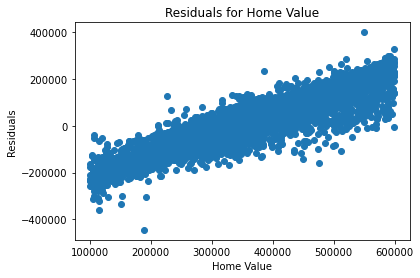

In [72]:
plot_residuals(y, yhat)